In [1]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import lightgbm as lgbm

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
def drop_features(df, feat_to_drop):
    
    df = df.drop(feat_to_drop, 1)
    
    return df

def selected_features(selected):
    
    for i, j in tuple(zip(X.columns, selected)):
        if j:
            print(f'- {i}')

In [29]:
input_folder = Path('../data/interim/')
train_file = Path('train_feature_engineering_v1.csv')
test_file = Path('test_feature_engineering_v1.csv')
output_train = Path('train_prepared.csv')
output_test = Path('test_prepared.csv')

seed = 1337
feat_to_drop = list()

In [4]:
train = pd.read_csv(input_folder/train_file, index_col=0)
test = pd.read_csv(input_folder/test_file, index_col=0)

df = pd.concat([train, test])

## Highly Correlated Features

In [5]:
num_feat = list()
remove_feat = ['Id', 'Cover_Type', 'Cardinal', 'Stoneyness']

for col in df.columns:
    if df[col].dtypes != 'O' and col not in remove_feat:
        num_feat.append(col)

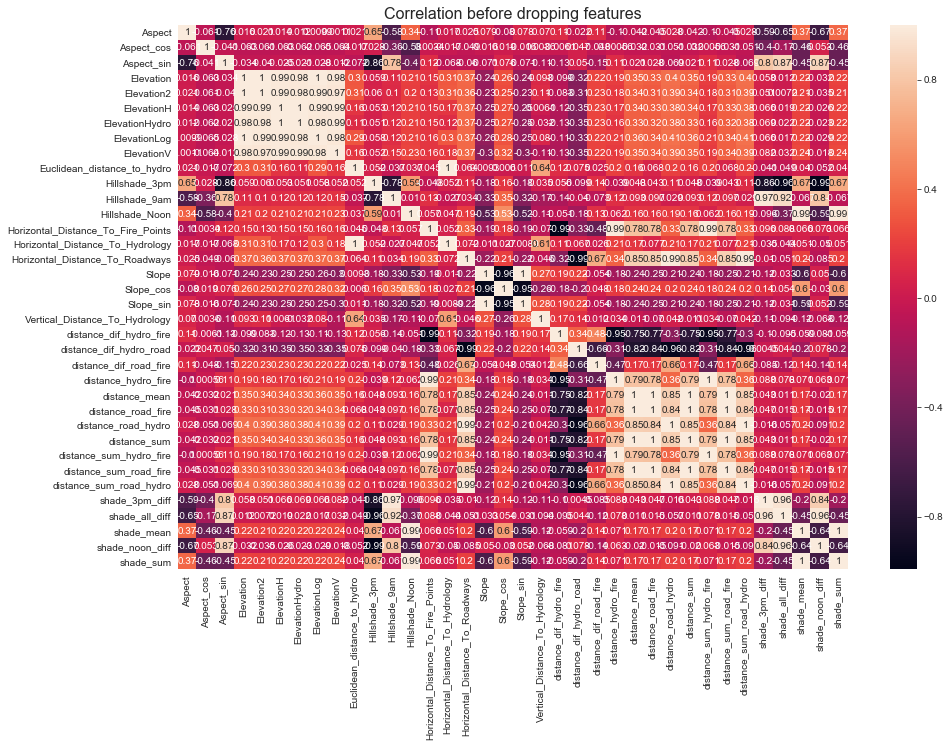

In [6]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_feat].corr(), annot=True)
plt.title('Correlation before dropping features', fontsize=16)
plt.show()

In [7]:
corr_feats = abs(df[num_feat].corr()) > .6
corr_feats['Total'] = corr_feats.sum(axis=1)

high_corr_feats = corr_feats['Total'][corr_feats['Total'] >= 10].index.to_list()

num_feat = list()
num_feat = list()
remove_feat = ['Id', 'Cover_Type', 'Cardinal', 'Stoneyness']

for col in df.columns:
    if df[col].dtypes != 'O' and col not in remove_feat and col not in high_corr_feats:
        num_feat.append(col)

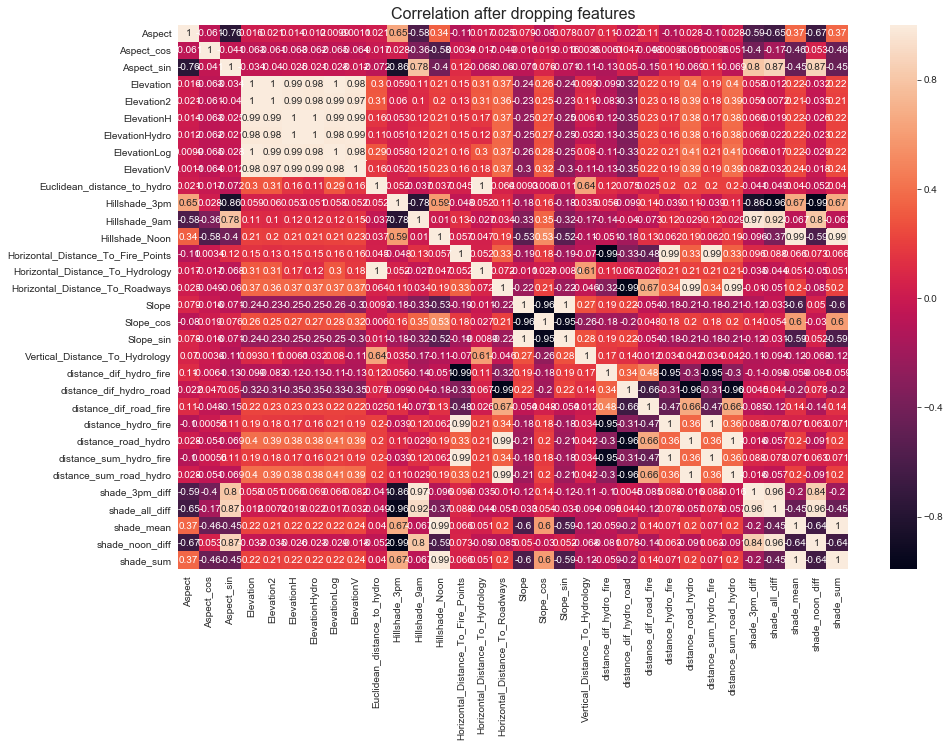

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_feat].corr(), annot=True)
plt.title('Correlation after dropping features', fontsize=16)
plt.show()

In [9]:
df = drop_features(df, high_corr_feats)

In [10]:
relevant_soils = df['SoilType'].value_counts(normalize=True)[df['SoilType'].value_counts(normalize=True) > .01].\
index.tolist()

In [11]:
df['SoilType'] = df['SoilType'].apply(lambda x: x if x in relevant_soils else 'Outros')

### Preparing dataset for feature selection

In [12]:
le = LabelEncoder()

for col in df.columns:
    if df[col].dtypes == 'O':
        df[col] = le.fit_transform(df[col])
        
train = df[df['Cover_Type'].notnull()]
train['Cover_Type'] = train['Cover_Type'].astype('int')

test = df[df['Cover_Type'].isnull()].drop('Cover_Type', 1)

X = train.drop(['Cover_Type', 'Id'], 1)
scaled_X = MinMaxScaler().fit_transform(X)
y = train['Cover_Type']

## Embedded

In [13]:
rf_selector_model = RandomForestClassifier(random_state=seed)
et_selector_model = ExtraTreesClassifier(random_state=seed)
lr_selector_model = LogisticRegression(penalty='l1')

threshold = 'median'

rf_selector = SelectFromModel(rf_selector_model, threshold=threshold)
et_selector = SelectFromModel(et_selector_model, threshold=threshold)
lr_selector = SelectFromModel(lr_selector_model, threshold=threshold)

print('> Fitting random forest selector')
rf_selector.fit(X, y)
rf_feats = rf_selector.get_support()
print(f'> {sum(rf_feats)} selected features')
print('> Selected features:')
display(selected_features(rf_feats))

print('> Fitting extra trees selector')
et_selector.fit(X, y)
et_feats = et_selector.get_support()
print(f'> {sum(et_feats)} selected features')
print('> Selected features:')
display(selected_features(et_feats))

print('> Fitting logistic regression selector')
lr_selector.fit(scaled_X, y)
lr_feats = lr_selector.get_support()
print(f'> {sum(lr_feats)} selected features')
print('> Selected features:')
display(selected_features(lr_feats))

> Fitting random forest selector
> 18 selected features
> Selected features:
- Aspect_cos
- Elevation
- Elevation2
- ElevationH
- ElevationHydro
- ElevationLog
- ElevationV
- Euclidean_distance_to_hydro
- Horizontal_Distance_To_Roadways
- SoilType
- Wilderness
- distance_dif_hydro_fire
- distance_dif_hydro_road
- distance_dif_road_fire
- distance_hydro_fire
- distance_road_hydro
- distance_sum_hydro_fire
- distance_sum_road_hydro


None

> Fitting extra trees selector
> 18 selected features
> Selected features:
- Aspect_cos
- Elevation
- Elevation2
- ElevationH
- ElevationHydro
- ElevationLog
- ElevationV
- Euclidean_distance_to_hydro
- Horizontal_Distance_To_Fire_Points
- Horizontal_Distance_To_Hydrology
- Horizontal_Distance_To_Roadways
- SoilType
- Stoneyness
- Wilderness
- distance_dif_hydro_road
- distance_dif_road_fire
- distance_road_hydro
- distance_sum_road_hydro


None

> Fitting logistic regression selector
> 18 selected features
> Selected features:
- Aspect_sin
- Elevation2
- ElevationHydro
- ElevationLog
- Hillshade_3pm
- Hillshade_9am
- Hillshade_Noon
- Horizontal_Distance_To_Hydrology
- Slope_cos
- Slope_sin
- SoilType
- Vertical_Distance_To_Hydrology
- Wilderness
- distance_dif_hydro_fire
- distance_dif_hydro_road
- shade_3pm_diff
- shade_mean
- shade_sum


None

## Wrapper

In [14]:
lgbm_selector_model = lgbm.LGBMClassifier(n_estimators=50, random_state=seed, n_jobs=-1)
lgbm_rfe_selector = RFE(lgbm_selector_model, n_features_to_select=18, verbose=3)
lgbm_rfe_selector.fit(X, y)
lgbm_rfe_feats = lgbm_rfe_selector.get_support()
print('> Selected features:')
display(selected_features(lgbm_rfe_feats))

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
> Selected features:
- Aspect_cos
- Elevation
- ElevationH
- ElevationHydro
- ElevationV
- Euclidean_distance_to_hydro
- Hillshade_9am
- Hillshade_Noon
- Horizontal_Distance_To_Fire_Points
- Horizontal_Distance_To_Roadways
- SoilType
- Wilderness
- distance_dif_hydro_fire
- distance_dif_hydro_road
- distance_dif_road_fire
- distance_hydro_fire
- dist

None

## Filter

In [20]:
best_selector = SelectKBest(k=18, score_func=chi2)

best_selector.fit(scaled_X, y)
kbest_feats = best_selector.get_support()
selected_features(kbest_feats)

- Aspect_cos
- Elevation
- Elevation2
- ElevationH
- ElevationHydro
- ElevationLog
- ElevationV
- Euclidean_distance_to_hydro
- Horizontal_Distance_To_Fire_Points
- Horizontal_Distance_To_Hydrology
- Horizontal_Distance_To_Roadways
- SoilType
- Stoneyness
- Wilderness
- distance_hydro_fire
- distance_road_hydro
- distance_sum_hydro_fire
- distance_sum_road_hydro


## Ensembling Feature Selection

In [25]:
rf_feats, et_feats, lr_feats, lgbm_rfe_feats

data = {
    'RF_feats': rf_feats, 
    'ET_feats': et_feats, 
    'LR_feats': lr_feats, 
    'RFE_LGBM_feats': lgbm_rfe_feats,
    'KBest_feats': kbest_feats
}

results = pd.DataFrame(data, index=X.columns)
results['Total'] = results.sum(axis=1)

final_features = results[results['Total'] >= 2].index.tolist()

print(f'Number of features for modelling: {len(final_features)}')
display(results.loc[final_features])

Number of features for modelling: 24


,RF_feats,ET_feats,LR_feats,RFE_LGBM_feats,KBest_feats,Total
Aspect_cos,True,True,False,True,True,4
Elevation,True,True,False,True,True,4
Elevation2,True,True,True,False,True,4
ElevationH,True,True,False,True,True,4
ElevationHydro,True,True,True,True,True,5
ElevationLog,True,True,True,False,True,4
ElevationV,True,True,False,True,True,4
Euclidean_distance_to_hydro,True,True,False,True,True,4
Hillshade_9am,False,False,True,True,False,2
Hillshade_Noon,False,False,True,True,False,2


In [30]:
train_prepared = train[final_features]
test_prepared = test[final_features]

train_prepared.to_csv(input_folder/output_train)
test_prepared.to_csv(input_folder/output_test)